In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from statsmodels.formula.api import ols
from statsmodels.graphics import tsaplots
import warnings

Restructure the data frame to a usable format 

In [3]:
#get .gov data from the csv
excel_file = 'Gov_data/Consolidated_data.xlsx'
customer_trans_df = pd.read_excel(excel_file, 'Customer_transfers')
inflation_df = pd.read_excel(excel_file, 'Inflation')
fuel_prices_df = pd.read_excel(excel_file, 'Domestic_food_prices')
weekly_earnings_df = pd.read_excel(excel_file, 'Weekly_earnings')
intrest_rate_df = pd.read_excel(excel_file, 'Interest_rate')

combined_df = pd.DataFrame([])

#Include year and month 
for i in [customer_trans_df,inflation_df,fuel_prices_df,weekly_earnings_df,intrest_rate_df]:
    i['month'] = i['date'].dt.month
    i['year'] = i['date'].dt.year
    i.drop('date' ,axis = 1, inplace = True)

    #used for the intrest rate hikes and any future ones were there may be multiple changes in a month 
    i = i.groupby(['month','year']).max().reset_index()
    
    #works if the dataframe is empty 
    if len(combined_df) == 0:
        combined_df = i
    else:
        combined_df = combined_df.merge(i,on= ['month','year'],how = 'left')

#ffill to bring over correct intrest rate and bfill to take into account the first alue that isnt filled 
combined_df = combined_df.sort_values(['year','month']).fillna(method= 'ffill').fillna(method= 'bfill').drop('Gas Transfers',axis = 1).reset_index(drop = True)   

Explore the data

In [4]:
#will concentrate on electricity transfers 
combined_df.head()

,month,year,Electricity Transfers,inflation_index,Solid fuels,Gas,Electrcity,Liquid fuels,Pay(£),Rate
0,1,2003,326000,75.9,53.461975,44.591029,54.673496,41.864268,345.0,3.75
1,2,2003,337000,76.1,53.461975,44.591029,54.673496,49.223222,343.0,3.75
2,3,2003,368000,76.4,53.575482,44.591029,54.673496,50.695012,348.0,3.75
3,4,2003,351000,76.8,53.234960,44.722955,54.673496,37.939493,349.0,3.75
4,5,2003,327000,76.8,52.667423,44.986807,54.801536,35.650041,349.0,3.75


<AxesSubplot: >

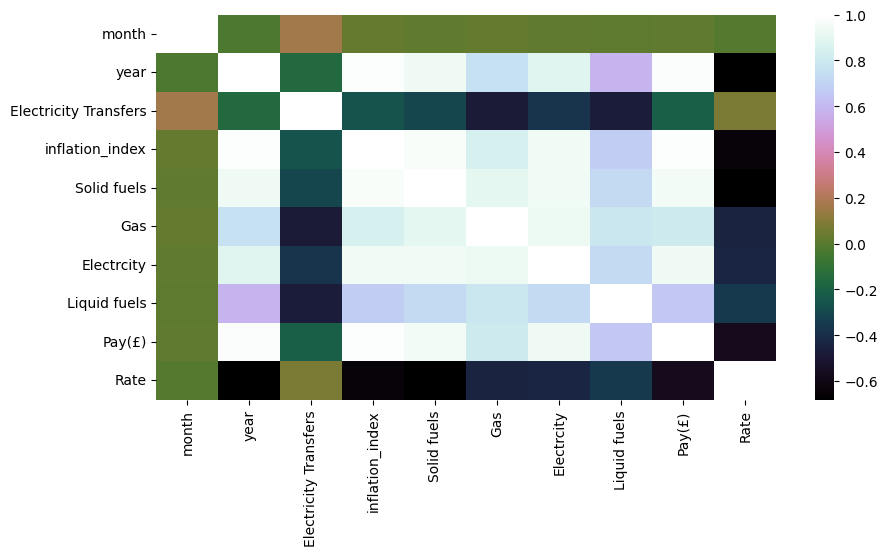

In [5]:
#find the strongest correlating factor to see if any can be reduced down 
plt.figure(figsize = (10,5))
sns.heatmap(combined_df.corr(),cmap="cubehelix")
#Strangely there is a negative correlation between transfers and prices
#maybe when prices are high people have other things on their mind over moving 

In [6]:
#Strangely there is a negative correlation between transfers and prices, maybe when prices are high people have other things on their mind over moving 
combined_df.columns

Index(['month', 'year', 'Electricity Transfers', 'inflation_index',
       'Solid fuels', 'Gas', 'Electrcity', 'Liquid fuels', 'Pay(£)', 'Rate'],
      dtype='object')

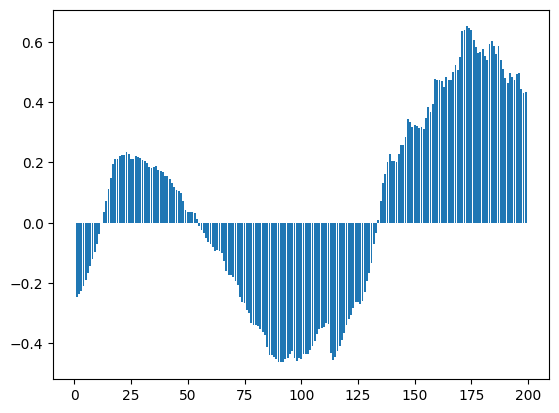

In [7]:
#introduce the change ratio to see if there is any difference 
metric = 'inflation_index'
# done at a month level
max_periods = 200

corr_df = pd.DataFrame([],columns = ['Lag','corr'])

for i in range(1,max_periods):
    lag_data = combined_df[metric].shift(-i)[:-i]
    sales_data = combined_df['Electricity Transfers'][:-i]

    corr_df_append = pd.DataFrame([[i,np.corrcoef(lag_data,sales_data)[0][1]]],columns = ['Lag','corr'])

    corr_df = pd.concat([corr_df,corr_df_append])

plt.bar(x= corr_df['Lag'],height = corr_df['corr'])

#used just for this run as runtime warning is not needed 
warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [ ]:
#Strong positive correlations from the last year showing around a 6 month lag with the change 
#A cyclical pattern over the years most likely bought on ebs and flows of the economy and people getting deals when switching after contracts
#no enough data however to extrapolate back more than a year

In [8]:
# Set the maximum and minimum number of periods for correlation calculation
max_periods = 60
min_periods = 12

# Define the columns of interest in the dataset
columns = combined_df.drop(['month', 'year'], axis=1).columns

# Create an empty DataFrame to store the correlation results
corr_df_fin = pd.DataFrame()

# Loop through each metric and calculate correlations with electricity transfers
for metric in columns:
    corr_df = pd.DataFrame()
    
    for i in range(min_periods, max_periods):
        # Calculate the correlation between metric and electricity transfers with lag
        lag_data = combined_df[metric].shift(-i)[:-i]
        sales_data = combined_df['Electricity Transfers'][:-i]
        corr_value = np.corrcoef(lag_data, sales_data)[0][1]

        corr_df = pd.concat([corr_df, pd.DataFrame({'days_change': [i], 'corr': [corr_value]})], ignore_index=True)

    # Find the number of periods with maximum correlation
    opt_days = int(corr_df.iloc[corr_df['corr'].abs().idxmax()]['days_change'])

    # Calculate the percentage change and add to the original DataFrame
    perc_change_data = (combined_df[metric] - combined_df[metric].shift(-opt_days)) / combined_df[metric].shift(-opt_days)
    combined_df[f'{metric} {opt_days} days'] = perc_change_data

In [10]:
combined_df.head(5)

,month,year,Electricity Transfers,inflation_index,Solid fuels,Gas,Electrcity,Liquid fuels,Pay(£),Rate,Electricity Transfers 58 days,inflation_index 23 days,Solid fuels 39 days,Gas 12 days,Electrcity 23 days,Liquid fuels 38 days,Pay(£) 23 days,Rate 12 days
0,1,2003,326000,75.9,53.461975,44.591029,54.673496,41.864268,345.0,3.75,-0.316562,-0.034351,-0.183709,-0.034286,-0.112266,-0.437980,-0.077540,0.000000
1,2,2003,337000,76.1,53.461975,44.591029,54.673496,49.223222,343.0,3.75,-0.180049,-0.028097,-0.192110,-0.045198,-0.125000,-0.357524,-0.090186,-0.062500
2,3,2003,368000,76.4,53.575482,44.591029,54.673496,50.695012,348.0,3.75,0.098507,-0.026752,-0.174825,-0.058496,-0.132114,-0.342524,-0.069519,-0.062500
3,4,2003,351000,76.8,53.234960,44.722955,54.673496,37.939493,349.0,3.75,-0.204082,-0.025381,-0.178634,-0.063536,-0.137374,-0.507431,-0.074271,-0.062500
4,5,2003,327000,76.8,52.667423,44.986807,54.801536,35.650041,349.0,3.75,-0.313025,-0.029077,-0.194444,-0.060606,-0.138833,-0.551440,-0.076720,-0.117647


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'month'),
  Text(1, 0, 'year'),
  Text(2, 0, 'Electricity Transfers'),
  Text(3, 0, 'inflation_index'),
  Text(4, 0, 'Solid fuels'),
  Text(5, 0, 'Gas'),
  Text(6, 0, 'Electrcity'),
  Text(7, 0, 'Liquid fuels'),
  Text(8, 0, 'Pay(£)'),
  Text(9, 0, 'Rate'),
  Text(10, 0, 'Electricity Transfers 58 days'),
  Text(11, 0, 'inflation_index 23 days'),
  Text(12, 0, 'Solid fuels 39 days'),
  Text(13, 0, 'Gas 12 days'),
  Text(14, 0, 'Electrcity 23 days'),
  Text(15, 0, 'Liquid fuels 38 days'),
  Text(16, 0, 'Pay(£) 23 days'),
  Text(17, 0, 'Rate 12 days')])

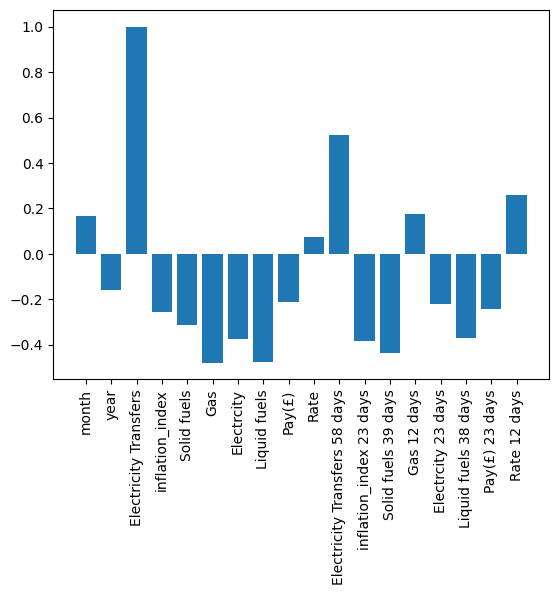

In [28]:
#find the highest correlating factors so they can be orders 
transfer_variable = combined_df.corr()['Electricity Transfers']

plt.bar(transfer_variable.index,transfer_variable.values)
plt.xticks(rotation = 90)

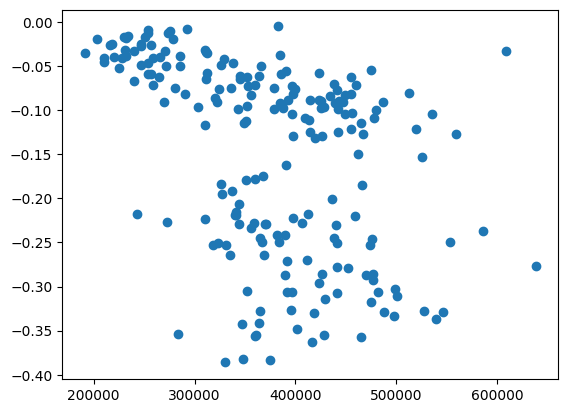

In [27]:
#understand if the relationships are linear and can be used for the model 
linear_variable = 'Solid fuels 39 days'

plt.scatter(combined_df['Electricity Transfers'],combined_df[linear_variable])

In [30]:
#Some values look like they have little relation and may not be suitable for a price elasticity model.
#We must therefore deduce the R^2 for a line of best fit to find the best factors to use
transfer_variable

month                            0.165195
year                            -0.159249
Electricity Transfers            1.000000
inflation_index                 -0.257053
Solid fuels                     -0.310873
Gas                             -0.478478
Electrcity                      -0.373061
Liquid fuels                    -0.474854
Pay(£)                          -0.211225
Rate                             0.075077
Electricity Transfers 58 days    0.524182
inflation_index 23 days         -0.381935
Solid fuels 39 days             -0.437183
Gas 12 days                      0.175482
Electrcity 23 days              -0.219382
Liquid fuels 38 days            -0.370895
Pay(£) 23 days                  -0.241983
Rate 12 days                     0.259631
Name: Electricity Transfers, dtype: float64

In [48]:
import statsmodels.api as sm

model = sm.OLS(combined_df['Electricity Transfers'],combined_df['Gas'])
results = model.fit()
print(results.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Electricity Transfers   R-squared (uncentered):                   0.686
Model:                               OLS   Adj. R-squared (uncentered):              0.685
Method:                    Least Squares   F-statistic:                              529.8
Date:                   Sun, 30 Jul 2023   Prob (F-statistic):                    6.94e-63
Time:                           16:10:47   Log-Likelihood:                         -3325.6
No. Observations:                    243   AIC:                                      6653.
Df Residuals:                        242   BIC:                                      6657.
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------